# Book Recommender - Vasilis Kontonis

The content of this Notebook is divided in the sections mentioned in the Table of Contents below.

At the first section I explore the three datasets downloaded from [this](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) link.<br>
After familiarizing myself with the data and the available information I choose a methodology to follow in the next section.

At the following section I apply the methodology and the chosen algorithm to build the recommender. The algorithm I choose is FunkSVD and I try two methodologies with respect to the data:
 1. Use only the explicit ratings.
 2. Use all the ratings, including implicit.

The idea is to apply the algorithm in both datasets and see with which way I achieve better performance results. Even though, it is known that in such cases implicit ratings is better to be treated separately, I do this expirimentation to see the difference in performance.<br>
We achieved better results using the explicit ratings only.

After finalizing the methodology and fine tuning the parameters of the algorithm I apply it to the whole dataset and save the final trained model.<br>

Finaly I create a function that uses the final model in order to make predictions and recommendations for a user (as input for the function).

At the last section there is a recap of what I have done through out this Notebook, the results and an additional way to measure the performance of this solution.

## Table of Contents

- [Data Exploration](#Exploratory-Data-Analysis)<br>
- [Matrix Factorization](#Matrix-Factorization)<br>
  - [Parameter Tuning](#Parameter-Tuning)<br>
  - [Final Model](#Final-Model)<br>
  - [Recommender Function](#Recommender-Function)<br>
  - [Save the Final Model](#Save-Model)<br>
- [Conclusion](#Conclusion)<br>

## Import all the necessary modules

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.externals import joblib

%matplotlib inline

## Import the datasets

In [3]:
# load the available datasets
users = pd.read_csv("./data/BX-Users.csv", sep=";", error_bad_lines=False, encoding="latin-1")
ratings = pd.read_csv("./data/BX-Book-Ratings.csv", error_bad_lines=False, sep=";", encoding="latin-1")
books = pd.read_csv("./data/BX-Books.csv", sep=";", error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


## <a class="anchor" id="Exploratory-Data-Analysis">Explore the datasets</a>

In [4]:
print(users.shape)
users.head()

(278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
users.dtypes

User-ID       int64
Location     object
Age         float64
dtype: object

In [6]:
users.isnull().mean()

User-ID     0.000000
Location    0.000000
Age         0.397199
dtype: float64

Almost 40% of the users has missing age.

In [7]:
sorted(users.Age.unique())

[nan,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 113.0,
 114.0,
 115.0,
 116.0,
 118.0,
 119.0,
 123.0,
 124.0,
 127.0,
 128.0,
 132.0,
 133.0,
 136.0,
 137.0,
 138.0,
 140.0,
 141.0,
 143.0,
 146.0,
 147.0,
 148.0,
 151.0,
 152.0,
 156.0,
 157.0,
 159.0,


In [8]:
users.Age[(users.Age > 6) & (users.Age < 90)].shape[0] / users.Age.shape[0]

0.5979208055712943

Under the assumption that all ages between 7 and 89 are correct, this gives us only the 59% of the users with correct age. We could replace the rest 41% with the average age.

I find the 41% to be a great percentage for incorrect values and I cannot trust the values of the rest 59% as well.

In [9]:
users.Age = users.Age.fillna(users.Age.mean())

In [10]:
print(ratings.shape)
ratings.head()

(1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [11]:
ratings.dtypes

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

In [12]:
ratings.isnull().mean()

User-ID        0.0
ISBN           0.0
Book-Rating    0.0
dtype: float64

In [13]:
sorted(ratings["Book-Rating"].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

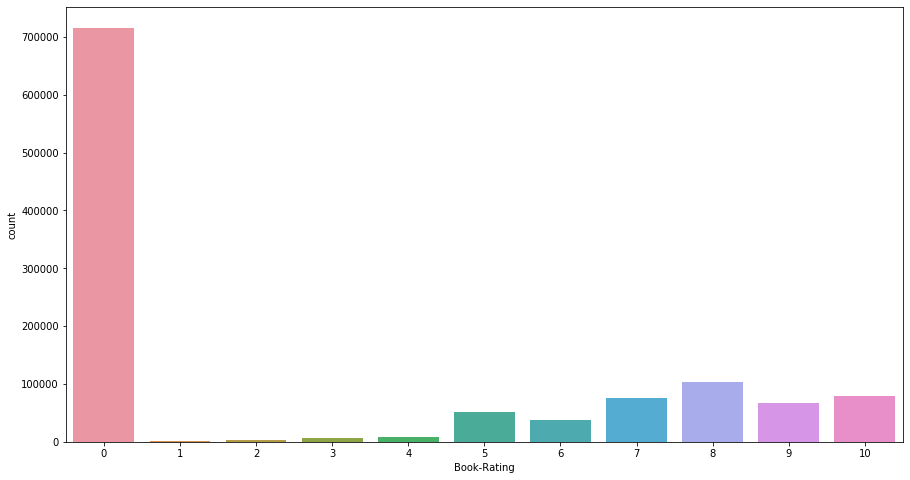

In [14]:
plt.figure(figsize=(15, 8))
sns.countplot(data=ratings, x="Book-Rating");

The number of implicit ratings is very high.

My approach will be as follows:
 1. Separate the implicit from explicit ratings
 2. Build a recommender using only the explicit ratings
 3. Build a recommender using the whole ratings dataset (implicit and explicit)
 4. Correct the recommendations for the user-item combinations that have implicit ratings (for example if the recommendation indicates that a user may like a book with a rating of 7 but we have implicit rating for this combination, we will correct the recommendation to 0)
 5. Compare the evaluation metrics from the above two methodologies and keep the best

In [15]:
#len(set(ratings.ISBN[ratings["Book-Rating"]==0]))

In [16]:
#len(set(ratings.ISBN[ratings["Book-Rating"]!=0]))

In [17]:
#len(set(ratings.ISBN[ratings["Book-Rating"]==0]).intersection(set(ratings.ISBN[ratings["Book-Rating"]!=0])))

In [18]:
explicit_ratings = ratings[ratings["Book-Rating"] != 0]
implicit_ratings = ratings[ratings["Book-Rating"] == 0]

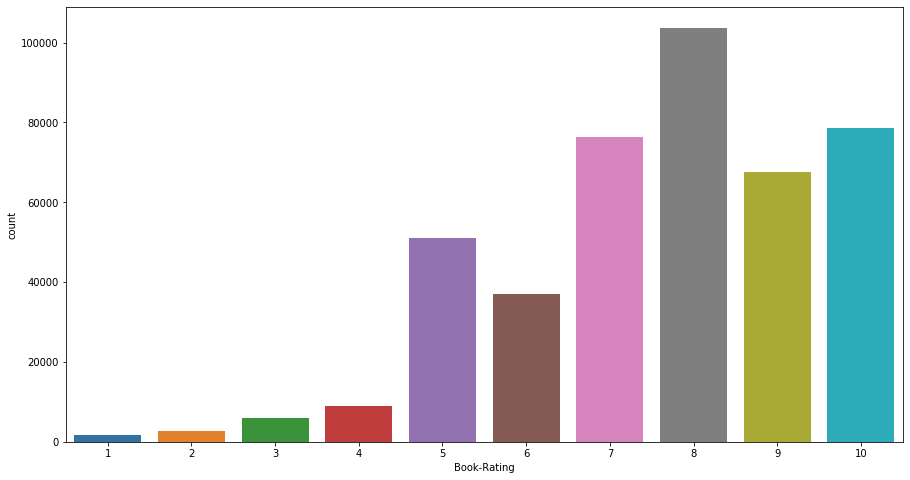

In [19]:
plt.figure(figsize=(15, 8))
sns.countplot(data=explicit_ratings, x="Book-Rating");

In [20]:
print(books.shape)
books.head()

(271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [21]:
books.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object

In [22]:
books.isnull().mean()

ISBN                   0.000000
Book-Title             0.000000
Book-Author            0.000004
Year-Of-Publication    0.000000
Publisher              0.000007
Image-URL-S            0.000000
Image-URL-M            0.000000
Image-URL-L            0.000011
dtype: float64

In [23]:
books["Book-Author"].isnull().sum(), books["Publisher"].isnull().sum()

(1, 2)

1 book has missing author. We will replace it with "Unknown".

2 book has missing publisher. We will replace it with "Unknown" as well.

In [24]:
books["Book-Author"][books["Book-Author"].isnull()] = "Unknown"
books["Publisher"][books["Publisher"].isnull()] = "Unknown"

Now let's check the Year-Of-Publication column, as I wouldn't expect it to be of type object.

In [25]:
books["Year-Of-Publication"].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

There are cases where the Year-Of-Publication:
 - has obviously took the value of Publisher 
 - some others that is 0 
 - and some others that is greater than 2019

In [26]:
print(books["Year-Of-Publication"][books["Year-Of-Publication"] == "0"].shape)
print(books["Year-Of-Publication"][books["Year-Of-Publication"] == "DK Publishing Inc"].shape)
print(books["Year-Of-Publication"][books["Year-Of-Publication"] == "Gallimard"].shape)

(1048,)
(2,)
(1,)


In [27]:
books[books["Year-Of-Publication"] == "0"].head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
196656,3442035368,Ich Gestehe,Heinz G. Konsalik,0,Wilhelm Goldmann Verlag GmbH,http://images.amazon.com/images/P/3442035368.0...,http://images.amazon.com/images/P/3442035368.0...,http://images.amazon.com/images/P/3442035368.0...
196678,0553124803,Being There,Jerzy Kosinski,0,Bantam Doubleday Dell,http://images.amazon.com/images/P/0553124803.0...,http://images.amazon.com/images/P/0553124803.0...,http://images.amazon.com/images/P/0553124803.0...
196680,888274387X,Vaniglia E Cioccolato,Modignani Casati,0,Sperling Paperback,http://images.amazon.com/images/P/888274387X.0...,http://images.amazon.com/images/P/888274387X.0...,http://images.amazon.com/images/P/888274387X.0...
196685,033368155X,Surreal Lives the Surrealists 1945,Ruth Brandon,0,Humanity Press/prometheus Bk,http://images.amazon.com/images/P/033368155X.0...,http://images.amazon.com/images/P/033368155X.0...,http://images.amazon.com/images/P/033368155X.0...
196734,0207158452,Games of the Strong,Glenda Adams,0,Harpercollins Publisher,http://images.amazon.com/images/P/0207158452.0...,http://images.amazon.com/images/P/0207158452.0...,http://images.amazon.com/images/P/0207158452.0...


In [28]:
books[books["Year-Of-Publication"] == "DK Publishing Inc"]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [29]:
books[books["Year-Of-Publication"] == "Gallimard"]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


Obviously in the last two cases Publisher has to take the value of Year-Of-Publication, Year-Of-Publication the value of Book-Author and Book-Author will be NaN and will be replaced by "Unknown".
Also we can drop the last 3 columns of the dataset regarding the image, as they don't seem to provide any usefull information.

In [30]:
books["Publisher"][books["Year-Of-Publication"] == "Gallimard"] = "Gallimard"
books["Book-Author"][books["Year-Of-Publication"] == "Gallimard"] = "Unknown"
books["Year-Of-Publication"][books["Year-Of-Publication"] == "Gallimard"] = "2003"

books["Publisher"][books["Year-Of-Publication"] == "DK Publishing Inc"] = "DK Publishing Inc"
books["Book-Author"][books["Year-Of-Publication"] == "DK Publishing Inc"] = "Unknown"
books["Year-Of-Publication"][books["Year-Of-Publication"] == "DK Publishing Inc"] = "2000"

In [31]:
books.drop(["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)

Finally, we will convert Year-Of-Publication to integer.

In [32]:
books["Year-Of-Publication"] = books["Year-Of-Publication"].astype(int)

In [33]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Now below we may see how many cases are 0 or greater than 2019.
It is only the 1.7% of the total records. 

I guess that we could replace their value with the average value of the rest cases.

In [34]:
books[(books["Year-Of-Publication"] == 0) | (books["Year-Of-Publication"] > 2019)].shape[0] / books.shape[0]

0.017080630896226415

At the following section I proceed with the model creation.<br>

I will only use the ratings dataset and I will apply the FunkSVD model.<br>

This model uses all the ratings in order to predict the ratings on books that users haven't read and rated.<br>
It is a very effective model, as it captures hidden trends and information from latent factors.

## <a class="anchor" id="Matrix-Factorization">Implementation of FunkSVD</a>

In [132]:
# train-test split
train_ratings, test_ratings = sk_train_test_split(explicit_ratings, test_size=0.2)

In [133]:
train_ratings.head()

,User-ID,ISBN,Book-Rating
903924,219208,0552140295,6
1120997,269009,0806524103,6
966342,233823,0312311818,1
575919,138543,0345432479,7
1017109,243814,0688149626,7


In [134]:
reader = Reader(rating_scale=(1, 10))

trainset = Dataset.load_from_df(train_ratings[["User-ID", "ISBN", "Book-Rating"]],\
                                reader=reader)

testset = Dataset.load_from_df(test_ratings[["User-ID", "ISBN", "Book-Rating"]],\
                               reader=reader)

In [135]:
trainset = trainset.build_full_trainset()

In [136]:
testset = testset.construct_testset(testset.raw_ratings)

In [137]:
svd = SVD(lr_all=.001, reg_all=.005, n_epochs=50, n_factors=20, verbose=True)

In [138]:
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


In [139]:
pred = svd.test(testset)

accuracy.rmse(pred, verbose=True)
accuracy.mae(pred, verbose=True)

RMSE: 1.6527
MAE:  1.2775


1.2775076218837547

## SVD on the whole dataset (including implicit ratings)


In [47]:
# train-test split
train_ratings_2, test_ratings_2 = sk_train_test_split(ratings, test_size=0.2, random_state=42)

reader = Reader(rating_scale=(0, 10))

trainset_2 = Dataset.load_from_df(train_ratings_2[["User-ID", "ISBN", "Book-Rating"]], reader=reader)
trainset_2 = trainset_2.build_full_trainset()

testset_2 = Dataset.load_from_df(test_ratings_2[["User-ID", "ISBN", "Book-Rating"]], reader=reader)
testset_2 = testset_2.construct_testset(testset_2.raw_ratings)

In [48]:
svd_2 = SVD(lr_all=.001, reg_all=.005, n_epochs=50, n_factors=20, verbose=True)

In [49]:
svd_2.fit(trainset_2)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


In [50]:
pred = svd_2.test(testset_2)

accuracy.rmse(pred, verbose=True)
accuracy.mae(pred, verbose=True)

RMSE: 3.4655
MAE:  2.7881


2.788131533497134

We expected that the scores woudn't be that good as in the previous methodology, because we have included the implicit ratings (zeros) in the dataset. This gives of course greater error from the predicted ratings.

Now, since we have available the information regarding the implicit ratings, we will use it to correct the predictions accordingly. Meaning that we will correct the predictions for the specific user-book combinations where we know (apriori) that the implicit rating is 0.

We will set all the predicted values for those combinations equal to zero and then calculate the accuracy metrics again.

In [51]:
corrected = pd.DataFrame(pred)
corrected.drop(["details"], axis=1, inplace=True)
corrected.est[corrected.r_ui==0] = 0

y_true = corrected.r_ui
y_hat = corrected.est

rmse = np.sqrt(mean_squared_error(y_true, y_hat))
mae = mean_absolute_error(y_true, y_hat)

print("Test RMSE: {}".format(rmse))
print("Test MAE: {}".format(mae))

Test RMSE: 2.7869662478406285
Test MAE: 1.5085850839621382


As we may see, implementing FunkSVD only on the explicit ratings dataset gives better performance in both metrics (RMSE and MAE) and so we will keep this methodology.

## <a class="anchor" id="Parameter-Tuning">Fine Tune the Parameters of FunkSVD with the Proposed Methodology</a>

In [52]:
reader = Reader(rating_scale=(1, 10))

dataset = Dataset.load_from_df(explicit_ratings[["User-ID", "ISBN", "Book-Rating"]],\
                               reader=reader)

In [130]:
# Parameter space
svd_param_grid = {'n_epochs': [50], 
                  'lr_all': [0.005, 0.01],
                  'reg_all': [0.005, 0.01],
                  'n_factors': [20, 50]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse'], cv=3)
svd_gs.fit(dataset)

In [131]:
print('SVD - RMSE:', round(svd_gs.best_score['rmse'], 4))

SVD - RMSE: 1.6635


In [242]:
print('RMSE =', svd_gs.best_params['rmse'])

RMSE = {'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.01, 'n_factors': 50}


## <a class="anchor" id="Final-Model">Final Model</a>

In [54]:
reader = Reader(rating_scale=(1, 10))

trainset = Dataset.load_from_df(explicit_ratings[["User-ID", "ISBN", "Book-Rating"]],\
                                reader=reader)

testset = Dataset.load_from_df(explicit_ratings[["User-ID", "ISBN", "Book-Rating"]],\
                               reader=reader)

trainset = trainset.build_full_trainset()
testset = testset.construct_testset(testset.raw_ratings)

In [55]:
svd_final = SVD(lr_all=.01, reg_all=.005, n_epochs=50, n_factors=50, verbose=True)

In [56]:
svd_final.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


In [57]:
pred = svd_final.test(testset)

In [58]:
final_preds = pd.DataFrame(pred)
final_preds.details = final_preds.details.apply(lambda x: list(x.values())[0])
final_preds.head()

,uid,iid,r_ui,est,details
0,276726,0155061224,5.0,5.376525,False
1,276729,052165615X,3.0,3.355660,False
2,276729,0521795028,6.0,5.932740,False
3,276736,3257224281,8.0,7.839762,False
4,276737,0600570967,6.0,6.307599,False


## Let's see an example of how our final model can make predictions for user-book combinations that do not exist in our dataset

In [59]:
# The user 276726 exists only once in our dataset with the book id 0155061224
final_preds[final_preds.uid==276726]

,uid,iid,r_ui,est,details
0,276726,0155061224,5.0,5.376525,False


In [60]:
# User 276729 exists twice
final_preds[final_preds.uid==276729]

,uid,iid,r_ui,est,details
1,276729,052165615X,3.0,3.35566,False
2,276729,0521795028,6.0,5.93274,False


In [61]:
# Let's see the predicted rating for user 276726 and book id 052165615X
svd_final.predict(uid=276726, iid='052165615X', verbose=True)

user: 276726     item: 052165615X r_ui = None   est = 6.16   {'was_impossible': False}


Prediction(uid=276726, iid='052165615X', r_ui=None, est=6.161978990421603, details={'was_impossible': False})

We can see that the predicted rating for user 276726 for the book 052165615X as the "est" at the output above. <br>
Next we will apply the model to predict the rating for all the user-book combinations that do not exist in our dataset (i.e. for each user for the books that have not rated yet, though have not read yet.)

In [62]:
# Unique users
users = pd.DataFrame(explicit_ratings["User-ID"].unique())
users.columns = ["user"]

# Unique books
books = pd.DataFrame(explicit_ratings["ISBN"].unique())
books.columns = ["book"]

In [63]:
users.shape[0], books.shape[0]

(77805, 185973)

We cannot create a dataset with all the user-book combinations due to memory issues.<br>
So we will continue with a function that takes as an input a specific user id and apply the model only to this user id and all the books s/he haven't rated.

## <a class="anchor" id="Recommender-Function">Recommender Function</a>

In [143]:
def user_recommendations(user_id, top_n=5, model=svd_final, data=explicit_ratings, user_column="User-ID", book_column="ISBN"):
    '''This function applies the model on all the user-book combination in order to predict the ratings.
       It returns the top_n recommendations for the given user, which are ratings for books the user have not rate (i.e. read) yet.
       
       Input:
           user_id: int - The user id for which you want to take recommendations
           top_n: int - How many recommendations you want for the user. Default is 5.
           model: The final model. Default is svd_final.
           data: df - User-Book-Ratings dataframe. Default is explicit_ratings.
           user_column: str - the name of the user id column in the given dataset. Default is "User-ID"
           book_column: str - the name of the book id column in the given dataset. Default is "ISBN"
           
       Output:
           top_recommendations: df - A dataframe with the top predicted books for the given user id.
    '''
    # Extract the given user id from the initial df
    users = pd.DataFrame(data[user_column][data[user_column]==user_id].unique())
    users.columns = ["user"]
    
    # Extract all the unique book ids from the initial df
    books = pd.DataFrame(data[book_column].unique())
    books.columns = ["book"]
    
    # Create all the user-book combinations for the given user id
    user_books_comb = users[users.user==user_id].assign(foo=1).merge(books.assign(foo=1)).drop('foo', 1)
    
    # Exclude all the user-book combinations for which we have a rating in the initial df
    unrated_combs = pd.merge(test, explicit_ratings, how='left', left_on=['user','book'], right_on=['User-ID','ISBN'])
    unrated_combs = unrated_combs[unrated_combs["Book-Rating"].isnull()][["user", "book"]].reset_index(drop=True)
    
    # Apply the model on all the above created user-books combinations
    pred_ratings = []
    for i in range(unrated_combs.shape[0]):
        book_id = unrated_combs.iloc[i, 1]
        score = model.predict(uid=user_id, iid=book_id, verbose=False).est
        pred_ratings.append(score)
    
    scores = pd.DataFrame(pred_ratings)
    scores.columns = ["scores"]
    predictions = pd.concat((unrated_combs, scores), axis=1)
    predictions = predictions.sort_values(by=['scores'], ascending=False)
    
    top_recommendations = predictions.iloc[:top_n]
    
    return top_recommendations

Below we apply the function for user 276729 in order to take the top 5 recommended books for this user.

In [144]:
top_5_recs_for_276729 = user_recommendations(user_id=276729)

In [145]:
top_5_recs_for_276729

,user,book,scores
1565,276729,059035342X,8.904334
49491,276729,0694003611,8.718192
3103,276729,055321313X,8.717648
4072,276729,0812550706,8.558485
3341,276729,0380012863,8.525181


## <a class="anchor" id="Save-Model">Save the Final Model</a>

In [142]:
filename = "./final_svd_model.sav"
joblib.dump(svd_final, filename)

['./final_svd_model.sav']

In [129]:
# With the following line you may load the model
# loaded_model = joblib.load(filename)

## <a class="anchor" id="Conclusion">Conclusion</a>

As we saw in this Notebook, we have worked only with the ratings dataset.

We built a FunkSVD model which takes into account the books a user has read and the respective rating.<br> Then it makes prediction for the rating on all the rest books that the user have not read.

We fine tuned the model and we managed to achieve the following RMSE: 1.6634 on the test set.

Finally, we created a function that uses the final model and makes recommendations for a specific user.<br> It predicts the rating for all the user-books combinations and returns only the top 5.

Please note that this recommendation engine is only for existing users and books.<br>

We could further monitor and evaluate our recommendations and measure the uplift with A/B testing after the deployment of the model.